# 图嵌入

### 为什么需要图嵌入
- 邻接矩阵维度高（$|V| \times |V|$），计算开销大
- 直接处理大规模图的原始表示效率低下

### 图嵌入的定义**本质上就是降维**
将高维稀疏矩阵映射到低维空间，得到的嵌入矩阵具有：
- 低维度（降维）
- 密集表示（每个元素都有意义，不像邻接矩阵主要是0和1）
- 整合了节点和连接信息

## 图嵌入作为矩阵分解问题**这个示例中我只用了节点和连接，没有包含每个节点的属性**

### 邻接矩阵 A
- 维度: $|V| \times |V|$，其中 $|V|$ 是图中节点数量
- 元素: $A_{ij} = 1$ 表示节点 $i$ 和节点 $j$ 之间有边，否则 $A_{ij} = 0$
- 示例（4节点图）:
  $$ A = \begin{bmatrix} 
  0 & 1 & 0 & 1 \\ 
  1 & 0 & 0 & 1 \\ 
  0 & 0 & 0 & 1 \\ 
  1 & 1 & 1 & 0 
  \end{bmatrix} $$

### 嵌入矩阵 Z
- 维度: $d \times |V|$，其中 $d$ 是嵌入维度 $(d \ll |V|)$
- 列: $Z$ 的第 $j$ 列是节点 $j$ 的嵌入向量 $\mathbf{z}_j$
- 示例（$d=2, |V|=4$）:
  $$ Z = \begin{bmatrix} 
  0.1 & 0.5 & -0.3 & 0.2 \\
  0.4 & -0.2 & 0.7 & 0.1 
  \end{bmatrix} $$

### 转置矩阵 $Z^T$
- 维度: $|V| \times d$
- 是 $Z$ 的转置，即行列互换
- 示例:
  $$ Z^T = \begin{bmatrix} 
  0.1 & 0.4 \\ 
  0.5 & -0.2 \\ 
  -0.3 & 0.7 \\ 
  0.2 & 0.1 
  \end{bmatrix} $$

## 图嵌入的目标
我们希望 $Z^T \cdot Z$ 近似于 $A$，即:
- 如果节点 $i$ 和 $j$ 在原图中相连 $(A_{ij}=1)$，它们的嵌入向量应该相似 $(\mathbf{z}_i^T \cdot \mathbf{z}_j$ 应该大$)$
- 如果节点 $i$ 和 $j$ 在原图中不相连 $(A_{ij}=0)$，它们的嵌入向量应该不相似 $(\mathbf{z}_i^T \cdot \mathbf{z}_j$ 应该小$)$

## 图嵌入的本质
- 寻找一个小矩阵能够轻量化表示原矩阵的有效信息
- 类似于特征矩阵，但嵌入更像是截断了的特征矩阵（指定了维度 $d$）
- 保留主要结构模式（信号），丢弃次要连接细节（噪声）
- 提高模型泛化性能

## 目标函数与距离度量

### 常用距离度量方法
1. 欧氏距离 (Euclidean Distance)
   - 公式: $d(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$
   - 特点：直观，对应物理空间中的直线距离
   - 适用场景：数据分布均匀，各维度重要性相近

2. 余弦相似度 (Cosine Similarity)
   - 公式：$\cos(\theta) = \frac{x \cdot y}{\|x\| \|y\|} = \frac{\sum_{i=1}^{n} x_i y_i}{\sqrt{\sum_{i=1}^{n} x_i^2} \sqrt{\sum_{i=1}^{n} y_i^2}}$
   - 特点：测量两个向量方向的相似度，不考虑大小
   - 适用场景：文本分析、推荐系统，向量大小不重要的场合

### 以欧式距离为例的优化目标
- Frobenius范数: $\min_Z \|A - Z^T \cdot Z\|_F^2$
- 展开后: $\|A - Z^T \cdot Z\|_F^2 = \sum_i \sum_j (A_{ij} - (Z^T \cdot Z)_{ij})^2 = \sum_i \sum_j (A_{ij} - \mathbf{z}_i^T \cdot \mathbf{z}_j)^2$

## 简化为逐对优化
总和可以分解为所有节点对 $(i,j)$ 的单独优化问题:
$$ \min_Z \sum_i \sum_j (A_{ij} - \mathbf{z}_i^T \cdot \mathbf{z}_j)^2 $$

对于每对节点 $(i,j)$:
- 如果 $A_{ij}=1$，我们希望 $\mathbf{z}_i^T \cdot \mathbf{z}_j$ 尽可能接近1
- 如果 $A_{ij}=0$，我们希望 $\mathbf{z}_i^T \cdot \mathbf{z}_j$ 尽可能接近0

## 随机梯度下降求解
使用随机梯度下降(SGD)优化目标函数:
1. 随机初始化 $Z$
2. 对每个边 $(i,j)$，计算当前预测值 $\mathbf{z}_i^T \cdot \mathbf{z}_j$ 与实际值 $A_{ij}$ 的误差
3. 根据误差更新 $\mathbf{z}_i$ 和 $\mathbf{z}_j$

例如，对于边 $(i,j)$，梯度更新可以写为:
$$ \begin{align}
\text{error} &= A_{ij} - \mathbf{z}_i^T \cdot \mathbf{z}_j \\
\mathbf{z}_i &= \mathbf{z}_i + \eta \cdot \text{error} \cdot \mathbf{z}_j \\
\mathbf{z}_j &= \mathbf{z}_j + \eta \cdot \text{error} \cdot \mathbf{z}_i
\end{align} $$

其中 $\eta$ 是学习率。

### **梯度更新公式详细拆解**
对于特定的一对节点$(i,j)$，其对应的损失函数项是：
$$J_{ij}(Z) = (A_{ij} - \mathbf{z}_i^T \cdot \mathbf{z}_j)^2$$

我们需要计算$J_{ij}$关于$\mathbf{z}_i$和$\mathbf{z}_j$的梯度：

1. 关于$\mathbf{z}_i$的梯度：
  $$\frac{\partial J_{ij}}{\partial \mathbf{z}_i} = \frac{\partial}{\partial \mathbf{z}_i}(A_{ij} - \mathbf{z}_i^T \cdot \mathbf{z}_j)^2 = -2(A_{ij} - \mathbf{z}_i^T \cdot \mathbf{z}_j) \cdot \mathbf{z}_j$$

  如果我们定义误差$\text{error} = A_{ij} - \mathbf{z}_i^T \cdot \mathbf{z}_j$，那么：
  $$\frac{\partial J_{ij}}{\partial \mathbf{z}_i} = -2 \cdot \text{error} \cdot \mathbf{z}_j$$

2. 类似地，关于$\mathbf{z}_j$的梯度是：
  $$\frac{\partial J_{ij}}{\partial \mathbf{z}_j} = -2 \cdot \text{error} \cdot \mathbf{z}_i$$

### 梯度更新

应用梯度下降公式：
$$\mathbf{z}_i = \mathbf{z}_i - \eta \cdot \frac{\partial J_{ij}}{\partial \mathbf{z}_i} = \mathbf{z}_i + \eta \cdot 2 \cdot \text{error} \cdot \mathbf{z}_j$$
$\eta$ 是学习率，也就是每次更新的步长

$$\mathbf{z}_j = \mathbf{z}_j - \eta \cdot \frac{\partial J_{ij}}{\partial \mathbf{z}_j} = \mathbf{z}_j + \eta \cdot 2 \cdot \text{error} \cdot \mathbf{z}_i$$

通常，我们会将$2$吸收到学习率$\eta$中，所以最终的更新公式就变成了：
$$\mathbf{z}_i = \mathbf{z}_i + \eta \cdot \text{error} \cdot \mathbf{z}_j$$
$$\mathbf{z}_j = \mathbf{z}_j + \eta \cdot \text{error} \cdot \mathbf{z}_i$$

这个过程本质上就是在让连接的节点嵌入向量更相似（向量点积更大），让不连接的节点嵌入向量更不相似（向量点积更小）。

-----
### 下面我们将简单实现一个embedding过程

In [1]:
import networkx as nx
# networkx库自带了很多图数据
G = nx.karate_club_graph()
#查看数据类型
type(G)

networkx.classes.graph.Graph

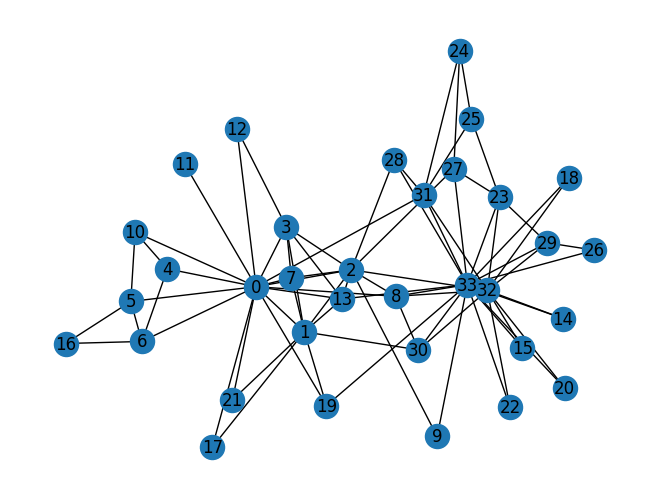

In [19]:
nx.draw(G, with_labels=True)

-----
**斯坦福cs224w 24fall 课程已经把传统图特征工程的单独部分省去了，一部分节点级的特征值被放到了embedding的colab中，其中pagerank的算法也就是google 创始人用的给不同网页的重要度打分的算法特别重要，我在下面的markdown补充了详细内容**

### PageRank

#### 基本思想
**重要性传递**：一个节点的重要性取决于有多少个节点连接到它，以及这些链接到它的节点有多重要

#### 数学公式
$$PR(u) = (1-d) + d \sum_{v \in B_u} \frac{PR(v)}{L(v)}$$
其中：
- $PR(u)$：节点 $u$ 的PageRank值
- $d$：阻尼系数（通常为0.85）
- $B_u$：指向节点 $u$ 的所有节点集合
- $L(v)$：节点 $v$ 的出度（指向其他节点的边数）
- $(1-d)$：随机跳转因子，确保图的连通性


#### 算法步骤
1. 初始化：$t=1$ 时给所有节点分配相同的PageRank值 $$PR_1(u) = 1/n$$
2. 迭代计算：$t+1$ 时，$$PR_{t+1}(u) = (1-d) + d \sum_{v \in B_u} \frac{PR_t(v)}{L(v)}$$
3. 迭代终点：当连续两次迭代的PR变化小于设定阈值时，算法收敛
   - 数学上可以证明，当图是强连通的或添加了随机跳转因子(代码中的alpha参数)时，算法一定会收敛

#### PageRank与马尔可夫链
PageRank本质上是一个马尔可夫链的稳态分布

##### 马尔可夫链定义
- 一种随机过程，下一个状态的概率分布仅依赖于当前状态，而与之前的状态无关
- 数学表示：$$P(X_{t+1}=j|X_t=i,X_{t-1}=i_{t-1},...,X_0=i_0) = P(X_{t+1}=j|X_t=i)$$

##### 马尔可夫链关键性质
1. **不可约性**：从任何状态都可以到达任何其他状态（随机跳转因子确保了这一点）
2. **非周期性**：系统不会陷入循环
3. **稳态分布**：满足上述条件的马尔可夫链会收敛到唯一的稳态分布，这正是PageRank值

In [2]:
def avg_degree(G):
    """
    计算图的平均度数
    
    参数:
    G: networkx图对象
    
    返回:
    float: 平均度数，表示图中每个节点平均连接的边数，值越大表示网络连接越密集
    """
    degrees = [G.degree(node) for node in G.nodes()]
    return sum(degrees) / len(degrees)

def avg_clustering_coefficient(G):
    """
    计算图的平均聚类系数
    
    参数:
    G: networkx图对象
    
    返回:
    float: 平均聚类系数，表示图中节点的邻居之间连接的紧密程度，值越大表示社区结构越明显
    """
    # 可以直接使用networkx内置函数计算更高效
    clustering_coeffs = nx.clustering(G)
    return sum(clustering_coeffs.values()) / len(clustering_coeffs)
    
    # 下面是手动实现聚类系数的计算方法（保留作为参考）
    """
    clustering_coefficients = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        n_neighbors = len(neighbors)
        if n_neighbors < 2: #如果节点有0或1个邻居，聚类系数为0
            clustering_coefficients.append(0)
            continue
        possible_triangles = n_neighbors * (n_neighbors - 1) / 2
        actual_triangles = 0  
        for i in range(n_neighbors):
            for j in range(i+1, n_neighbors):
                if G.has_edge(neighbors[i], neighbors[j]):
                    actual_triangles += 1
        clustering_coefficient = actual_triangles / possible_triangles
        clustering_coefficients.append(clustering_coefficient)

    return sum(clustering_coefficients) / len(clustering_coefficients)
    """

def pagerank(G, alpha=0.85, max_iter=100, tol=1e-6):
    """
    实现PageRank算法计算节点重要性
    
    参数:
    G: networkx图对象
    alpha: 阻尼系数，表示随机游走继续的概率
    max_iter: 最大迭代次数
    tol: 收敛容差
    
    返回:
    dict: 包含每个节点的PageRank值的字典，值越大表示节点越重要
    """
    # 使用networkx内置函数（可选）
    # return nx.pagerank(G, alpha=alpha, max_iter=max_iter, tol=tol)
    
    # 手动实现PageRank算法
    n = len(G.nodes())
    pr = {node: 1/n for node in G.nodes()}
    
    for _ in range(max_iter):
        new_pr = {node: (1-alpha)/n for node in G.nodes()}
        
        for node in G.nodes():
            # 对于每个节点，计算所有指向它的节点的贡献
            for neighbor in G.neighbors(node):
                new_pr[neighbor] += alpha * pr[node] / G.degree(node)
        
        # 检查收敛性
        if max(abs(new_pr[node] - pr[node]) for node in G.nodes()) < tol:
            break
            
        pr = new_pr.copy()
    
    # 归一化
    s = sum(pr.values())
    return {node: round(val/s, 4) for node, val in pr.items()}

def node_closeness_centrality(G, node):
    """
    计算指定节点的接近中心性
    
    参数:
    G: networkx图对象
    node: 要计算中心性的节点
    
    返回:
    float: 接近中心性值，表示节点到其他所有节点的平均距离的倒数，值越大表示节点位置越中心
    """
    # 使用networkx内置函数
    # return nx.closeness_centrality(G, node)
    
    # 手动实现接近中心性计算
    distances = nx.single_source_shortest_path_length(G, node)
    
    # 如果图不是连通的，某些节点可能不可达
    if len(distances) < len(G.nodes()):
        return 0  # 对于不可达的情况返回0
    
    # 计算到其他所有节点的平均距离的倒数
    distance_sum = sum(distances.values())
    if distance_sum > 0:
        return (len(G.nodes()) - 1) / distance_sum
    else:
        return 0

In [3]:
print(f"平均度数: {avg_degree(G):.2f}")
print(f"平均聚类系数: {avg_clustering_coefficient(G):.2f}")
print(f"PageRank值: {pagerank(G)}")
print(f"节点0的接近中心性: {node_closeness_centrality(G, 0):.4f}")

平均度数: 4.59
平均聚类系数: 0.57
PageRank值: {0: 0.097, 1: 0.0529, 2: 0.0571, 3: 0.0359, 4: 0.022, 5: 0.0291, 6: 0.0291, 7: 0.0245, 8: 0.0298, 9: 0.0143, 10: 0.022, 11: 0.0096, 12: 0.0146, 13: 0.0295, 14: 0.0145, 15: 0.0145, 16: 0.0168, 17: 0.0146, 18: 0.0145, 19: 0.0196, 20: 0.0145, 21: 0.0146, 22: 0.0145, 23: 0.0315, 24: 0.0211, 25: 0.021, 26: 0.015, 27: 0.0256, 28: 0.0196, 29: 0.0263, 30: 0.0246, 31: 0.0372, 32: 0.0717, 33: 0.1009}
节点0的接近中心性: 0.5690


------
### 接下来就是embedding 部分了

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [7]:
def graph_to_edge_list(G):
    """
    将NetworkX图转换为边列表
    
    参数:
    G: networkx图对象
    
    返回:
    list: 包含所有边的列表，每条边表示为(源节点,目标节点)的元组
    """
    edge_list = []
    for edge in G.edges():
        # 由于是无向图，每条边只添加一次
        edge_list.append((edge[0], edge[1]))
    return edge_list

def edge_list_to_tensor(edge_list):
    """
    将边列表转换为PyTorch张量
    
    参数:
    edge_list: 边列表
    
    返回:
    torch.Tensor: 边列表的tensor表示，形状为[2, num_edges]
    """
    # 将边列表转换为源节点列表和目标节点列表
    src_nodes = [edge[0] for edge in edge_list]
    dst_nodes = [edge[1] for edge in edge_list]
    # 创建形状为[2, num_edges]的tensor，便于图神经网络处理
    edge_index = torch.tensor([src_nodes, dst_nodes])
    return edge_index

def sample_negative_edges(G, num_samples):
    """
    采样不存在于图中的边（负样本）
    
    参数:
    G: networkx图对象
    num_samples: 需要采样的负边数量
    
    返回:
    list: 负边列表，每条边表示为(源节点,目标节点)的元组
    """
    import random
    # 获取现有边列表，用于检查边是否已存在
    existing_edges = set(G.edges())
    # 添加反向边，因为我们处理的是无向图
    existing_edges.update([(v, u) for u, v in existing_edges])
    # 添加自环，因为我们不希望采样自环
    existing_edges.update([(u, u) for u in G.nodes()])
    
    nodes = list(G.nodes())
    neg_edges = []
    
    # 随机采样负边直到达到指定数量
    while len(neg_edges) < num_samples:
        # 随机选择两个节点
        u = random.choice(nodes)
        v = random.choice(nodes)
        
        # 确保边不存在于图中
        if (u, v) not in existing_edges:
            neg_edges.append((u, v))
            # 将这条边添加到existing_edges中，避免重复采样
            existing_edges.add((u, v))
            existing_edges.add((v, u))  # 添加反向边
            
    return neg_edges

def create_edge_tensors(G, neg_samples_ratio=1.0):
    """
    创建正边和负边的tensor表示，用于模型训练
    
    参数:
    G: networkx图对象
    neg_samples_ratio: 负样本与正样本的比例
    
    返回:
    tuple: (pos_edge_index, neg_edge_index)，分别是正边和负边的tensor表示
    """
    # 获取正边
    pos_edge_list = graph_to_edge_list(G)
    pos_edge_index = edge_list_to_tensor(pos_edge_list)
    
    # 采样负边
    num_neg_samples = int(len(pos_edge_list) * neg_samples_ratio)
    neg_edge_list = sample_negative_edges(G, num_neg_samples)
    neg_edge_index = edge_list_to_tensor(neg_edge_list)
    
    return pos_edge_index, neg_edge_index

# 测试边是否可以作为负边
def can_be_negative_edge(G, edge):
    """
    检查一条边是否可以作为负样本（即边不存在于图中）
    
    参数:
    G: networkx图对象
    edge: 要检查的边，表示为(源节点,目标节点)的元组
    
    返回:
    bool: 如果边可以作为负样本则返回True，否则返回False
    """
    return not G.has_edge(edge[0], edge[1]) and edge[0] != edge[1]

In [8]:
# 创建训练数据
pos_edge_index, neg_edge_index = create_edge_tensors(G)
print(f"正边数量: {pos_edge_index.shape[1]}")
print(f"负边数量: {neg_edge_index.shape[1]}")
print(f"负边示例: {sample_negative_edges(G, 5)}")
print(f"边(0,1)可以作为负边？{can_be_negative_edge(G, (0, 1))}")
print(f"边(0,33)可以作为负边？{can_be_negative_edge(G, (0, 33))}")

正边数量: 78
负边数量: 78
负边示例: [(4, 25), (4, 29), (20, 27), (9, 30), (4, 2)]
边(0,1)可以作为负边？False
边(0,33)可以作为负边？True


In [9]:
# 嵌入层示例
def embedding_example():
    """
    演示PyTorch嵌入层的基本用法
    """
    # 初始化一个嵌入层，4个节点被嵌入，每个节点被嵌入为8维向量
    emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
    
    # 创建节点ID tensor
    ids = torch.LongTensor([0, 1, 2, 3])
    
    # 查看嵌入结果
    print("嵌入层结果:")
    print(emb_sample(ids))
    
    # 查看嵌入层的权重，等同于上面的结果
    print("\n嵌入层权重 (相同结果):")
    print(emb_sample.weight.data)
    
    # 手动初始化嵌入层的权重全为1
    print("\n手动设置权重为全1后:")
    emb_sample.weight.data = torch.ones(emb_sample.weight.data.shape)
    print(emb_sample.weight.data)


In [10]:
# 调用示例函数
embedding_example()

嵌入层结果:
tensor([[-0.1045,  1.0043,  0.8802, -0.7802,  0.6542, -1.3673, -2.2161, -2.1438],
        [-0.2561, -0.6029, -0.2802,  1.3360, -2.5764, -1.2057, -0.1606,  1.5451],
        [-0.7041, -0.3066,  0.2268, -0.1306,  0.7101,  0.5016, -1.9887,  1.0862],
        [-0.7620, -1.5477,  0.9251,  0.6008, -0.0507, -1.0313, -0.0586, -0.0932]],
       grad_fn=<EmbeddingBackward0>)

嵌入层权重 (相同结果):
tensor([[-0.1045,  1.0043,  0.8802, -0.7802,  0.6542, -1.3673, -2.2161, -2.1438],
        [-0.2561, -0.6029, -0.2802,  1.3360, -2.5764, -1.2057, -0.1606,  1.5451],
        [-0.7041, -0.3066,  0.2268, -0.1306,  0.7101,  0.5016, -1.9887,  1.0862],
        [-0.7620, -1.5477,  0.9251,  0.6008, -0.0507, -1.0313, -0.0586, -0.0932]])

手动设置权重为全1后:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])


In [11]:
def initialize_emb(num_nodes=34, embedding_dim=16, seed=1):
    """
    初始化图节点的嵌入层
    
    参数:
    num_nodes: 图中节点的数量
    embedding_dim: 嵌入维度
    seed: 随机种子，保证结果可复现
    
    返回:
    nn.Embedding: 初始化好的嵌入层
    """
    # 设置随机种子以确保结果可重现
    torch.manual_seed(seed)
    
    # 创建嵌入层
    emb = nn.Embedding(num_nodes, embedding_dim)
    
    # 使用均匀分布初始化权重
    nn.init.uniform_(emb.weight, -0.1, 0.1)
    
    return emb

# 初始化并测试嵌入层
def test_embedding():
    """测试嵌入层初始化"""
    # 初始化嵌入层
    emb = initialize_emb(len(G.nodes()), 16)
    
    # 获取特定节点的嵌入
    ids = torch.LongTensor([0, 3])
    
    print(f"嵌入层: {emb}")
    print(f"\n节点 {ids.tolist()} 的嵌入向量:")
    print(emb(ids))
    print(f"\n嵌入维度: {emb.weight.data.shape}")


In [12]:
# 调用测试函数
test_embedding()

嵌入层: Embedding(34, 16)

节点 [0, 3] 的嵌入向量:
tensor([[-0.0577,  0.0467, -0.0713,  0.0929, -0.0413,  0.0590,  0.0034, -0.0440,
          0.0668, -0.0763, -0.0529,  0.0120,  0.0793, -0.0428, -0.0609, -0.0638],
        [ 0.0497,  0.0309, -0.0231,  0.0964,  0.0202, -0.0258, -0.0014,  0.0983,
          0.0672, -0.0074,  0.0980,  0.0439, -0.0532, -0.0910,  0.0581,  0.0938]],
       grad_fn=<EmbeddingBackward0>)

嵌入维度: torch.Size([34, 16])


In [19]:
def visualize_emb(emb, title="节点嵌入可视化"):
    """
    使用PCA将节点嵌入可视化为2D图
    
    参数:
    emb: 嵌入层
    title: 图表标题
    """
    # 获取嵌入权重
    X = emb.weight.data.numpy()
    
    # 使用PCA降维到2维以便可视化
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    
    # 绘制图形
    plt.figure(figsize=(8, 8))
    
    # 分别绘制两个俱乐部的节点
    club1_x, club1_y = [], []
    club2_x, club2_y = [], []
    
    for node in G.nodes(data=True):
        if node[1]['club'] == 'Mr. Hi':
            club1_x.append(components[node[0]][0])
            club1_y.append(components[node[0]][1])
        else:
            club2_x.append(components[node[0]][0])
            club2_y.append(components[node[0]][1])
    
    # 绘制散点图
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi Club", alpha=0.7, s=100)
    plt.scatter(club2_x, club2_y, color="blue", label="Officer Club", alpha=0.7, s=100)
    
    # 添加图例和标题
    plt.legend(fontsize=12)
    plt.title(title, fontsize=15)
    plt.xlabel("Principle Component 1", fontsize=12)
    plt.ylabel("Principle Component 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()

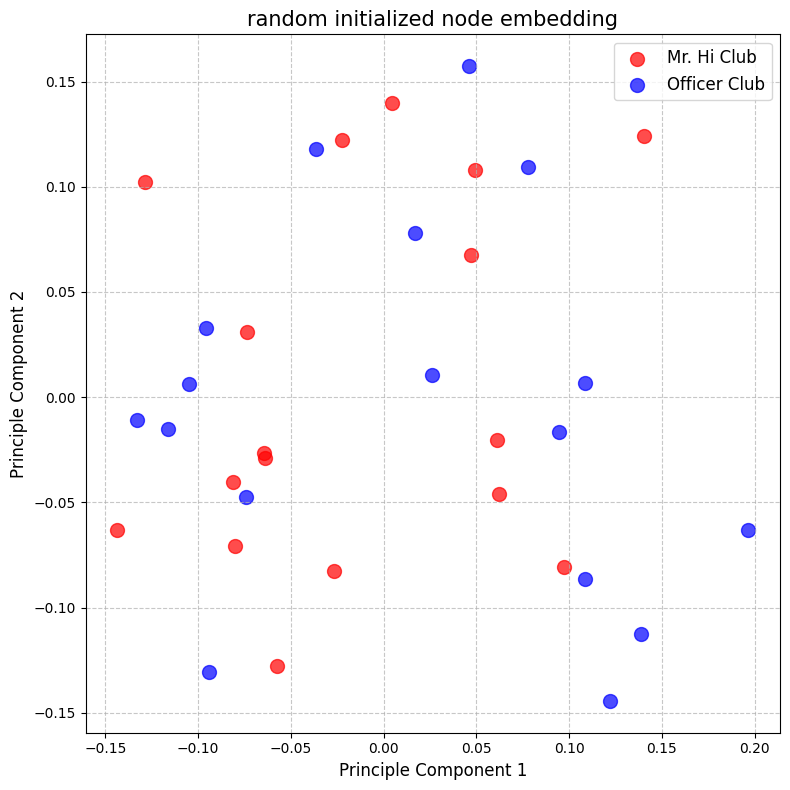

In [20]:
emb = initialize_emb(len(G.nodes()), 16)
visualize_emb(emb, "random initialized node embedding")

In [21]:
def accuracy(pred, label):
    """
    计算二分类预测的准确率
    
    参数:
    pred: 预测概率，值在0到1之间
    label: 真实标签，值为0或1
    
    返回:
    float: 准确率，正确预测的比例
    """
    # 将预测概率转换为二分类标签
    predicted_labels = (pred > 0.5).float()
    # 计算正确预测的数量
    correct = (predicted_labels == label).sum().item()
    # 计算总样本数量
    total = label.size(0)
    # 计算准确率
    accu = correct / total
    return accu

def train_embedding(emb, loss_fn, train_label, train_edge, epochs=500, learning_rate=0.1, verbose=True):
    """
    训练图嵌入模型
    
    参数:
    emb: 嵌入层
    loss_fn: 损失函数
    train_label: 训练标签 (0:负边, 1:正边)
    train_edge: 训练边，形状为[2, num_edges]
    epochs: 训练轮数
    learning_rate: 学习率
    verbose: 是否打印训练过程
    
    返回:
    nn.Embedding: 训练好的嵌入层
    """
    import torch.optim as optim
    
    # 使用随机梯度下降优化器SGD
    optimizer = optim.SGD(emb.parameters(), lr=learning_rate, momentum=0.9)
    
    # 保存训练历史
    loss_history = []
    accuracy_history = []
    
    # 训练循环
    for epoch in range(epochs):
        # 清零梯度
        optimizer.zero_grad()
        
        # 获取源节点和目标节点
        src_nodes = train_edge[0]
        dst_nodes = train_edge[1]
        
        # 获取节点嵌入
        src_embeds = emb(src_nodes)
        dst_embeds = emb(dst_nodes)
        
        # 计算点积作为相似度度量
        dot_products = torch.sum(src_embeds * dst_embeds, dim=1)
        
        # 应用sigmoid激活函数将点积映射到[0,1]
        predictions = torch.sigmoid(dot_products)
        
        # 计算损失
        loss = loss_fn(predictions, train_label)
        
        # 计算准确率
        accu = accuracy(predictions, train_label)
        
        # 记录历史
        loss_history.append(loss.item())
        accuracy_history.append(accu)
        
        # 打印训练进度
        if verbose and (epoch+1) % 50 == 0:  
            print(f'轮次 {epoch+1}/{epochs}, 损失: {loss.item():.4f}, 准确率: {accu:.4f}')
        
        # 反向传播
        loss.backward()
        
        # 更新参数  
        optimizer.step()
    
    if verbose:
        # 绘制训练曲线
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Train Loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(accuracy_history)
        plt.title('Train Accu')
        plt.xlabel('epoch')
        plt.ylabel('accu')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    return emb

# 训练图嵌入模型
def run_training():
    """执行完整的图嵌入训练流程"""
    import torch.nn as nn
    
    # 创建正边和负边数据
    pos_edge_index, neg_edge_index = create_edge_tensors(G)
    
    # 生成标签
    pos_label = torch.ones(pos_edge_index.shape[1])
    neg_label = torch.zeros(neg_edge_index.shape[1])
    
    # 合并标签
    train_label = torch.cat([pos_label, neg_label], dim=0)
    
    # 合并边数据
    train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    
    # 初始化嵌入层
    emb = initialize_emb(len(G.nodes()), embedding_dim=16)
    
    # 定义损失函数（二元交叉熵，适用于链接预测任务）
    loss_fn = nn.BCELoss()
    
    # 训练模型
    print("开始训练嵌入模型...")
    trained_emb = train_embedding(emb, loss_fn, train_label, train_edge, epochs=500)
    
    # 可视化训练后的嵌入
    visualize_emb(trained_emb, "Node embedding after Training")
    
    return trained_emb

开始训练嵌入模型...
轮次 50/500, 损失: 0.6859, 准确率: 0.8526
轮次 100/500, 损失: 0.6632, 准确率: 0.9295
轮次 150/500, 损失: 0.5871, 准确率: 0.9167
轮次 200/500, 损失: 0.4300, 准确率: 0.9359
轮次 250/500, 损失: 0.2858, 准确率: 0.9487
轮次 300/500, 损失: 0.1881, 准确率: 0.9808
轮次 350/500, 损失: 0.1225, 准确率: 0.9936
轮次 400/500, 损失: 0.0813, 准确率: 1.0000
轮次 450/500, 损失: 0.0565, 准确率: 1.0000
轮次 500/500, 损失: 0.0415, 准确率: 1.0000


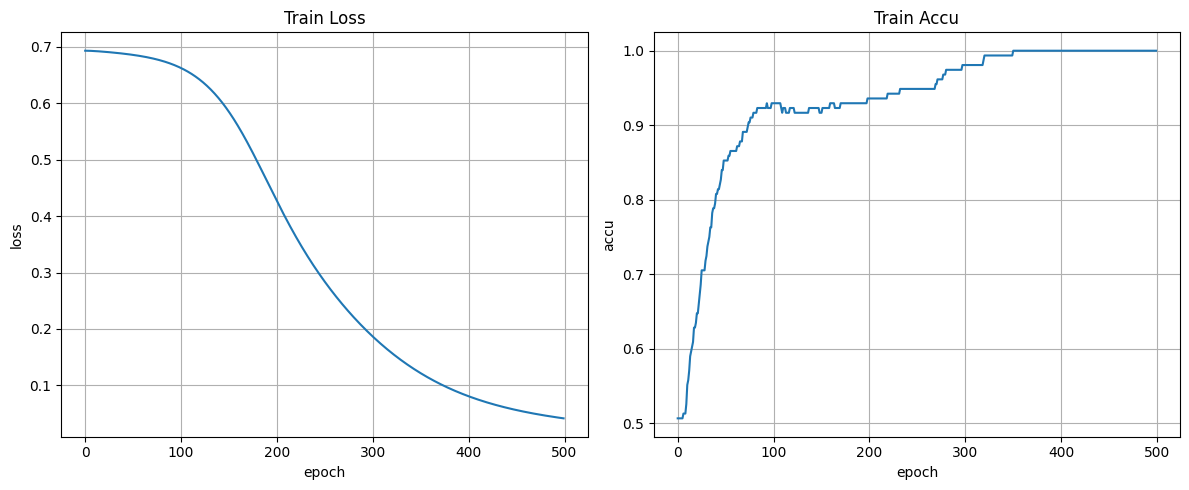

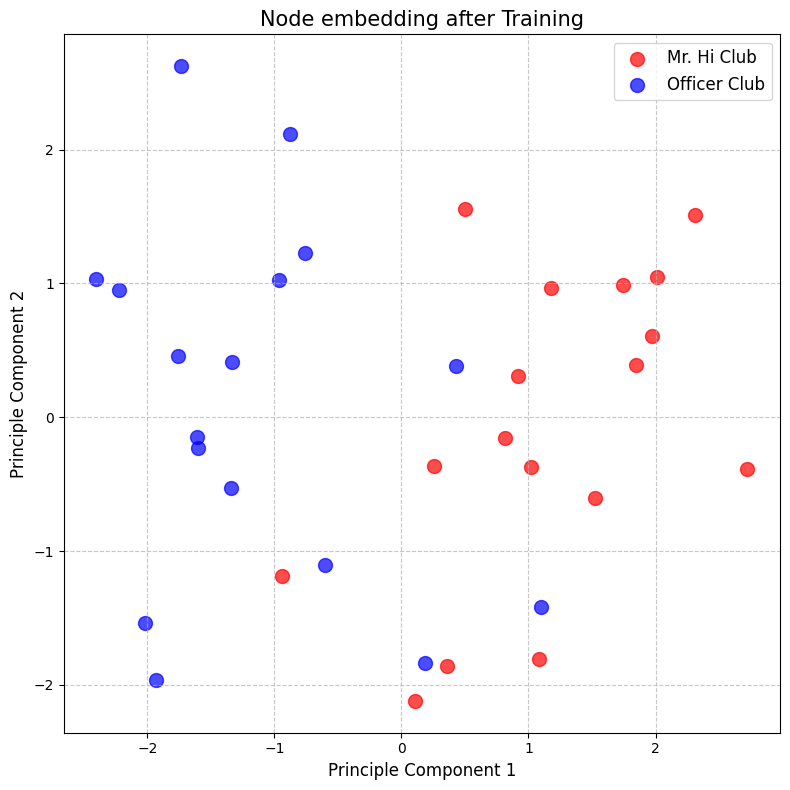

In [22]:
# 执行训练
trained_embedding = run_training()

In [17]:
# 使用训练好的嵌入进行链接预测
def predict_link(emb, node_i, node_j):
    """
    预测两个节点之间是否存在链接
    
    参数:
    emb: 训练好的嵌入层
    node_i, node_j: 节点索引
    
    返回:
    float: 两节点之间存在链接的概率
    """
    # 获取节点嵌入
    emb_i = emb(torch.LongTensor([node_i])).detach()
    emb_j = emb(torch.LongTensor([node_j])).detach()
    
    # 计算点积并应用sigmoid函数
    similarity = torch.sum(emb_i * emb_j).item()
    probability = torch.sigmoid(torch.tensor(similarity)).item()
    
    return probability

# 测试链接预测
def test_link_prediction():
    """测试链接预测功能"""
    # 测试已知存在的边
    existing_edge = (0, 1)  # 假设这条边存在于图中
    # 测试不存在的边
    non_existing_edge = (0, 10)  # 假设这条边不存在于图中
    
    prob_existing = predict_link(trained_embedding, existing_edge[0], existing_edge[1])
    prob_non_existing = predict_link(trained_embedding, non_existing_edge[0], non_existing_edge[1])
    
    print(f"\n链接预测结果:")
    print(f"边 {existing_edge} 存在的概率: {prob_existing:.4f}")
    print(f"边 {non_existing_edge} 存在的概率: {prob_non_existing:.4f}")

# 调用链接预测测试
test_link_prediction()




链接预测结果:
边 (0, 1) 存在的概率: 0.9997
边 (0, 10) 存在的概率: 0.9687
